# ACM 158 PS3 PROBLEM 3
Eduardo Beltrame

In [33]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from itertools import combinations
pd.set_option('display.max_colwidth', -1)


/Users/munfred/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


In [2]:
df = pd.read_csv('prostate_cancer.csv')

In [3]:
df

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train/test
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,1
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,1
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,1
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,1
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,1
...,...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,1
93,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,1
94,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,0
95,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,1


### Preprocess for zero mean and 1 variance

In [4]:
df.mean()

lcavol         1.350010
lweight        3.628943
age           63.865979
lbph           0.100356
svi            0.216495
lcp           -0.179366
gleason        6.752577
pgg45         24.381443
lpsa           2.478387
train/test     0.690722
dtype: float64

In [77]:
ddf = df - df.mean()
ddf = ddf/ddf.std()
ddf['train/test']=df['train/test']
ddf['svi']=df['svi']
ddf

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train/test
0,-1.637356,-2.006212,-1.862426,-1.024706,0,-0.863171,-1.042157,-0.864467,-2.520226,1
1,-1.988980,-0.722009,-0.787896,-1.024706,0,-0.863171,-1.042157,-0.864467,-2.287827,1
2,-1.578819,-2.188784,1.361163,-1.024706,0,-0.863171,0.342627,-0.155348,-2.287827,1
3,-2.166917,-0.807994,-0.787896,-1.024706,0,-0.863171,-1.042157,-0.864467,-2.287827,1
4,-0.507874,-0.458834,-0.250631,-1.024706,0,-0.863171,-1.042157,-0.864467,-1.825150,1
...,...,...,...,...,...,...,...,...,...,...
92,1.255920,0.577607,0.555266,-1.024706,1,1.073572,0.342627,1.262889,1.651834,1
93,2.096506,0.625489,-2.668323,-1.024706,1,1.679542,0.342627,0.553770,1.911116,1
94,1.321402,-0.543304,-1.593794,-1.024706,1,1.890377,0.342627,-0.509907,2.308473,0
95,1.300290,0.338384,0.555266,1.004813,1,1.242632,0.342627,1.972007,2.598152,1


### Part a) BSS with the Validation Set Approach

In [78]:
predictors = ddf.columns[:8]
train_idx = ddf[ddf['train/test']==1].index
test_idx = ddf[ddf['train/test']==0].index
results = pd.DataFrame(columns=['p','average_rss_train', 'average_rss_test', 'model'])

for p in range(0,9):
    models = ["lpsa ~ 1 + " + d for d in [" + ".join(map(str, comb)) for comb in combinations(predictors, p)]]
    if p == 0: models = ["lpsa ~ 1"]
    
    for model in models:
        y, X = dmatrices(model, data=ddf, return_type='dataframe')
        
        mod = sm.OLS(y.loc[train_idx], X.loc[train_idx]) 
        res = mod.fit()
        test_prediction = res.predict(X.loc[test_idx])

        test_residuals =  test_prediction - y.loc[test_idx]['lpsa']
        rss_test = np.dot(test_residuals, test_residuals)/len(test_residuals)

        train_prediction = res.predict(X.loc[train_idx])
        train_residuals =  train_prediction - y.loc[train_idx]['lpsa']
        rss_train = np.dot(train_residuals, train_residuals)/len(train_residuals)      
        
        results = results.append({'p':p,'average_rss_train':rss_train, 'average_rss_test':rss_test, 'model':model},ignore_index=True)

# for each P fetch the model with smallest test error        

best_models=pd.DataFrame()
for p in range(9):
    best_models=best_models.append(results.loc[results[results['p']==p]['average_rss_test'].idxmin()])

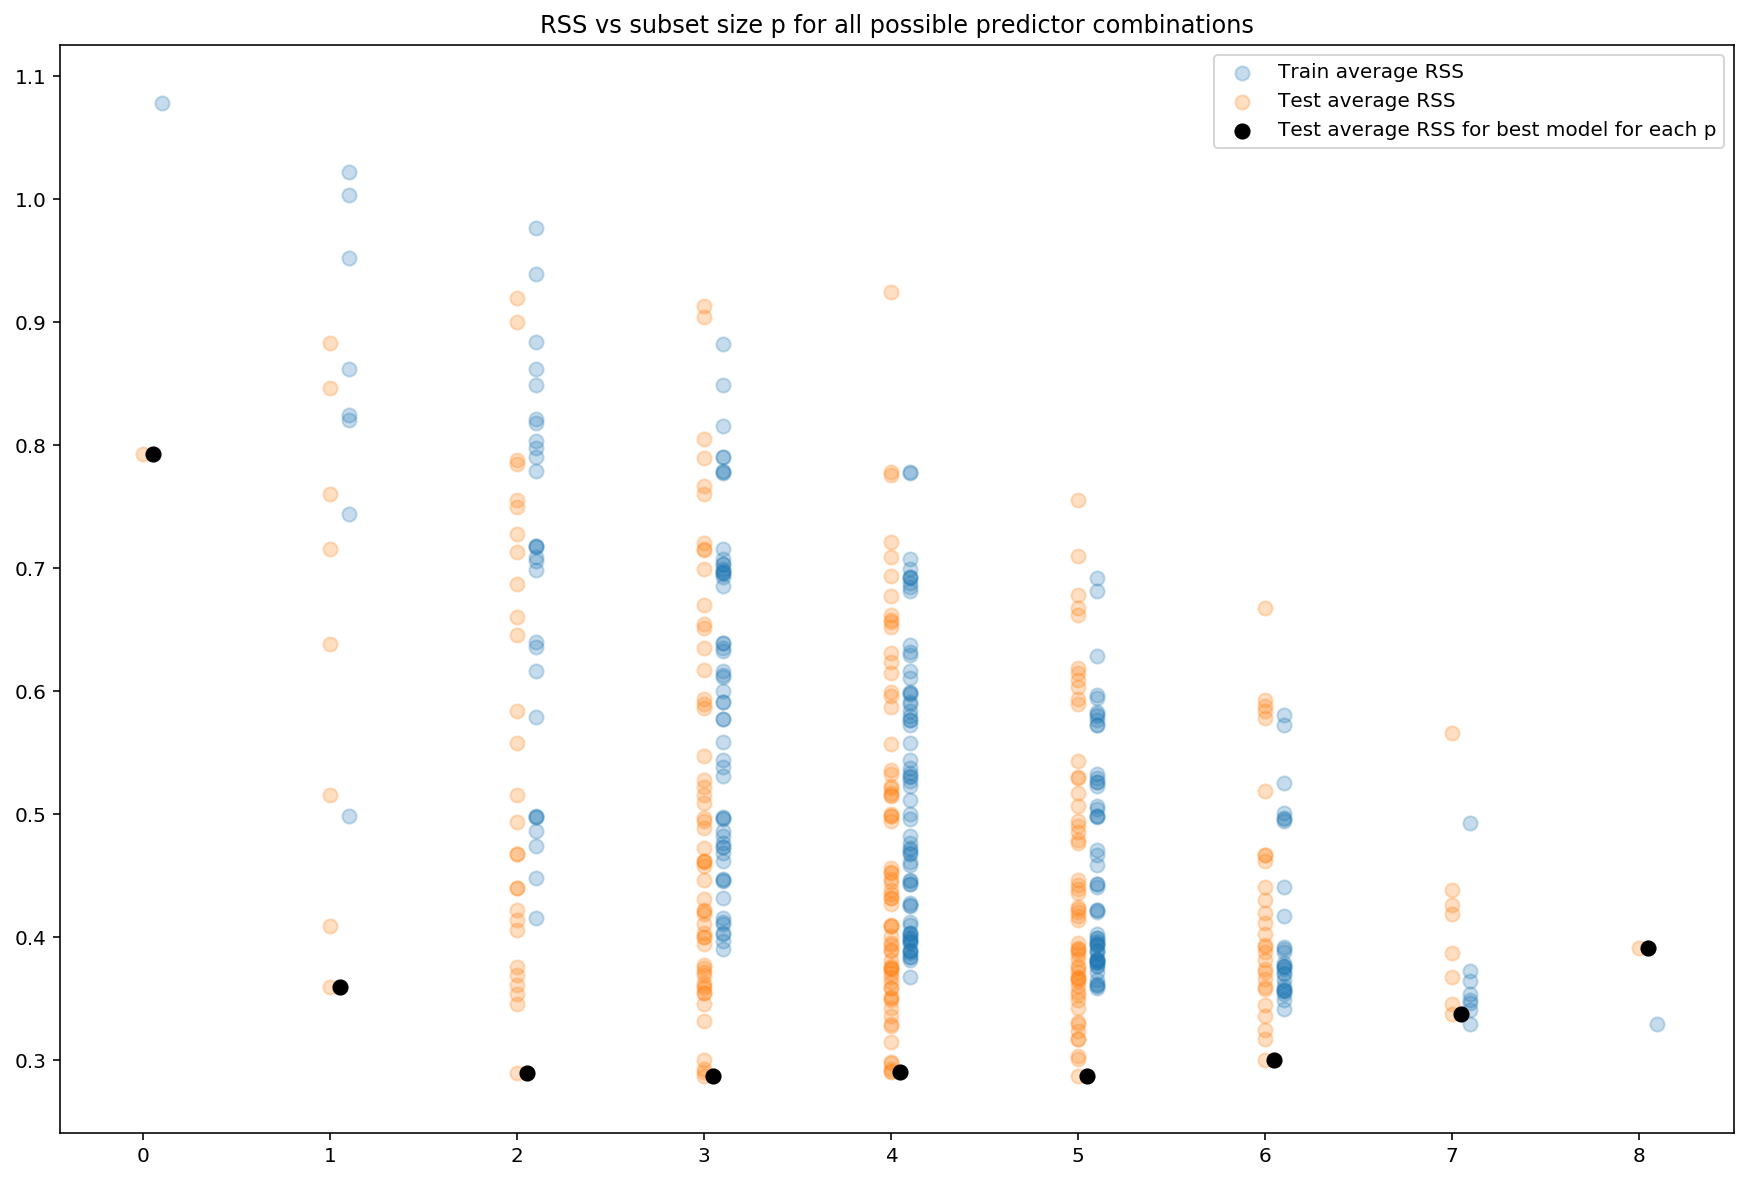

In [79]:


plt.figure(figsize=(15,10))
plt.scatter(x=results['p']+0.1,y=results['average_rss_train'], alpha = 0.25, s=50, label = 'Train average RSS')
plt.scatter(x=results['p'],y=results['average_rss_test'], alpha = 0.25, s=50, label = 'Test average RSS')
plt.scatter(x=best_models['p']+0.05,y=best_models['average_rss_test'], color = 'k', alpha = 1, s=50, label = 'Test average RSS for best model for each p')


plt.title(label='RSS vs subset size p for all possible predictor combinations')
plt.legend()
plt.show()


## Below we list our table with the best performing model according to the test RSS.

Overall Using p between 2 and 5 yields similar results, so we chose best performing model using p= 2 where we have:

$$ lpsa \sim 1 + lcavol + svi $$

$$ f(X) = -0.1085 +  0.6168  \cdot X_1 + 0.4694 \cdot X_5 $$




In [80]:
display(best_models)

,average_rss_test,average_rss_train,model,p
0,0.793060,1.078471,lpsa ~ 1,0.0
1,0.360036,0.498775,lpsa ~ 1 + lcavol,1.0
12,0.289776,0.473953,lpsa ~ 1 + lcavol + svi,2.0
53,0.287286,0.473443,lpsa ~ 1 + lcavol + svi + gleason,3.0
113,0.290501,0.472957,lpsa ~ 1 + lcavol + age + svi + gleason,4.0
168,0.287627,0.382749,lpsa ~ 1 + lcavol + lweight + age + svi + gleason,5.0
227,0.300428,0.376841,lpsa ~ 1 + lcavol + lweight + age + svi + gleason + pgg45,6.0
247,0.337540,0.346775,lpsa ~ 1 + lcavol + lweight + age + lbph + svi + lcp + gleason,7.0
255,0.391207,0.329612,lpsa ~ 1 + lcavol + lweight + age + lbph + svi + lcp + gleason + pgg45,8.0


Let's retrain that model and fetch the coefficients, which statsmodels conveniently returns to us in the results summary

In [81]:
y, X = dmatrices("lpsa ~ 1 + lcavol + svi", data=ddf, return_type='dataframe')

mod = sm.OLS(y.loc[train_idx], X.loc[train_idx]) 
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     40.82
Date:                Wed, 13 May 2020   Prob (F-statistic):           3.75e-12
Time:                        20:29:35   Log-Likelihood:                -70.056
No. Observations:                  67   AIC:                             146.1
Df Residuals:                      64   BIC:                             152.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1085      0.105     -1.038      0.3

Thus we get the following results:
```
Intercept   =  -0.1085     
lcavol      =   0.6168      
svi         =   0.4694
```